<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/stock_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 連接kaggle api
api_token = {"username":"victor830717","key":"e5ff0036288b15a13b2e2e4444e5051b"}
import json
import zipfile
import os

# 建資料夾 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
# !kaggle datasets download -d {kaggle資料集名稱} --force
!kaggle datasets download -d varpit94/ford-stock-data --force
 
!ls /kaggle

100% 230k/230k [00:00<00:00, 801kB/s]
100% 230k/230k [00:00<00:00, 800kB/s]
ford-stock-data.zip


In [4]:
! unzip ford-stock-data.zip

Archive:  ford-stock-data.zip
  inflating: F.csv                   


In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('F.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12563 entries, 0 to 12562
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12563 non-null  object 
 1   Open       12563 non-null  float64
 2   High       12563 non-null  float64
 3   Low        12563 non-null  float64
 4   Close      12563 non-null  float64
 5   Adj Close  12563 non-null  float64
 6   Volume     12563 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 687.2+ KB


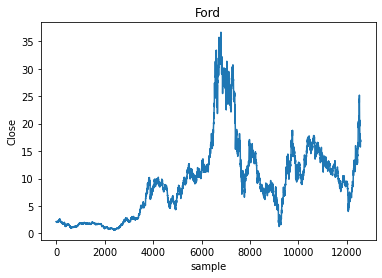

In [6]:
plt.plot(data['Close'])

plt.title('Ford')
plt.ylabel('Close')
plt.xlabel('sample')
plt.show()

In [7]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['Open'].rolling(window=7).mean(),name="Ford"),secondary_y=False,)
fig.update_layout(autosize=False,width=900,height=500,title_text="Ford")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

In [8]:
train = data[0:10000]
test = data[10001:-1]
test

,Date,Open,High,Low,Close,Adj Close,Volume
10001,2012-01-20,12.550000,12.640000,12.450000,12.590000,8.772728,43705700
10002,2012-01-23,12.690000,12.840000,12.550000,12.660000,8.821501,49379700
10003,2012-01-24,12.560000,12.860000,12.460000,12.820000,8.932989,45768400
10004,2012-01-25,12.800000,12.980000,12.700000,12.930000,9.009639,54021600
10005,2012-01-26,13.030000,13.050000,12.660000,12.790000,8.912088,75470700
...,...,...,...,...,...,...,...
12557,2022-03-17,16.230000,16.580000,16.160000,16.580000,16.580000,58500200
12558,2022-03-18,16.420000,16.900000,16.280001,16.860001,16.860001,89050700
12559,2022-03-21,16.870001,17.110001,16.330000,16.480000,16.480000,72583600
12560,2022-03-22,16.719999,17.309999,16.700001,17.090000,17.090000,77647100


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Open'].values.reshape(-1,1))
scaled_data

array([[0.        ],
       [0.05848045],
       [0.05837032],
       ...,
       [0.32618599],
       [0.3313463 ],
       [0.32672918]])

In [11]:
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-10):      ######
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+10, 0])      ###### predict 10 days after
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

array([[[0.        ],
        [0.05848045],
        [0.05837032],
        ...,
        [0.05550686],
        [0.05517646],
        [0.05473594]],

       [[0.05848045],
        [0.05837032],
        [0.05837032],
        ...,
        [0.05517646],
        [0.05473594],
        [0.05473594]],

       [[0.05837032],
        [0.05837032],
        [0.05770953],
        ...,
        [0.05473594],
        [0.05473594],
        [0.0546258 ]],

       ...,

       [[0.29685369],
        [0.29332295],
        [0.28626147],
        ...,
        [0.29848326],
        [0.29522412],
        [0.29386614]],

       [[0.29332295],
        [0.28626147],
        [0.27919999],
        ...,
        [0.29522412],
        [0.29386614],
        [0.28680466]],

       [[0.28626147],
        [0.27919999],
        [0.27132373],
        ...,
        [0.29386614],
        [0.28680466],
        [0.28897743]]])

In [12]:
print(x_train.shape)
print(y_train.shape)

(9960, 30, 1)
(9960,)


In [13]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [14]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=30,batch_size=32,callbacks=[checkpointer])

Epoch 1/30
311/312 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0048e-04

312/312 [==============================] - 12s 9ms/step - loss: 0.0034 - accuracy: 1.0040e-04
Epoch 2/30
311/312 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 11ms/step - loss: 0.0016 - accuracy: 1.0040e-04
Epoch 3/30
311/312 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 11ms/step - loss: 0.0015 - accuracy: 1.0040e-04
Epoch 4/30
310/312 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0081e-04

312/312 [==============================] - 4s 12ms/step - loss: 0.0012 - accuracy: 1.0040e-04
Epoch 5/30
310/312 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0081e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0012 - accuracy: 1.0040e-04
Epoch 6/30
309/312 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0113e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0012 - accuracy: 1.0040e-04
Epoch 7/30
310/312 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0081e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0011 - accuracy: 1.0040e-04
Epoch 8/30
312/312 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0010 - accuracy: 1.0040e-04
Epoch 9/30
307/312 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0179e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0011 - accuracy: 1.0040e-04
Epoch 10/30
311/312 [============================>.] - ETA: 0s - loss: 9.7507e-04 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.7486e-04 - accuracy: 1.0040e-04
Epoch 11/30
312/312 [==============================] - ETA: 0s - loss: 9.4774e-04 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.4774e-04 - accuracy: 1.0040e-04
Epoch 12/30
311/312 [============================>.] - ETA: 0s - loss: 9.4058e-04 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.4599e-04 - accuracy: 1.0040e-04
Epoch 13/30
307/312 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0179e-04

312/312 [==============================] - 3s 10ms/step - loss: 0.0010 - accuracy: 1.0040e-04
Epoch 14/30
312/312 [==============================] - ETA: 0s - loss: 9.7008e-04 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 10ms/step - loss: 9.7008e-04 - accuracy: 1.0040e-04
Epoch 15/30
310/312 [============================>.] - ETA: 0s - loss: 9.6944e-04 - accuracy: 1.0081e-04

312/312 [==============================] - 3s 10ms/step - loss: 9.7011e-04 - accuracy: 1.0040e-04
Epoch 16/30
308/312 [============================>.] - ETA: 0s - loss: 9.1919e-04 - accuracy: 1.0146e-04

312/312 [==============================] - 3s 10ms/step - loss: 9.1471e-04 - accuracy: 1.0040e-04
Epoch 17/30
310/312 [============================>.] - ETA: 0s - loss: 9.6947e-04 - accuracy: 1.0081e-04

312/312 [==============================] - 3s 10ms/step - loss: 9.6770e-04 - accuracy: 1.0040e-04
Epoch 18/30
310/312 [============================>.] - ETA: 0s - loss: 9.7205e-04 - accuracy: 1.0081e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.7069e-04 - accuracy: 1.0040e-04
Epoch 19/30
308/312 [============================>.] - ETA: 0s - loss: 9.1121e-04 - accuracy: 1.0146e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.1311e-04 - accuracy: 1.0040e-04
Epoch 20/30
309/312 [============================>.] - ETA: 0s - loss: 9.9405e-04 - accuracy: 1.0113e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.9651e-04 - accuracy: 1.0040e-04
Epoch 21/30
309/312 [============================>.] - ETA: 0s - loss: 9.1620e-04 - accuracy: 1.0113e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.1173e-04 - accuracy: 1.0040e-04
Epoch 22/30
312/312 [==============================] - ETA: 0s - loss: 8.9637e-04 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 9ms/step - loss: 8.9637e-04 - accuracy: 1.0040e-04
Epoch 23/30
312/312 [==============================] - ETA: 0s - loss: 9.1734e-04 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.1734e-04 - accuracy: 1.0040e-04
Epoch 24/30
307/312 [============================>.] - ETA: 0s - loss: 9.0267e-04 - accuracy: 1.0179e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.0411e-04 - accuracy: 1.0040e-04
Epoch 25/30
311/312 [============================>.] - ETA: 0s - loss: 8.9765e-04 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 9ms/step - loss: 8.9715e-04 - accuracy: 1.0040e-04
Epoch 26/30
311/312 [============================>.] - ETA: 0s - loss: 9.1235e-04 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.1193e-04 - accuracy: 1.0040e-04
Epoch 27/30
308/312 [============================>.] - ETA: 0s - loss: 9.3700e-04 - accuracy: 1.0146e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.4155e-04 - accuracy: 1.0040e-04
Epoch 28/30
307/312 [============================>.] - ETA: 0s - loss: 8.6363e-04 - accuracy: 1.0179e-04

312/312 [==============================] - 3s 9ms/step - loss: 8.6286e-04 - accuracy: 1.0040e-04
Epoch 29/30
312/312 [==============================] - ETA: 0s - loss: 8.9071e-04 - accuracy: 1.0040e-04

312/312 [==============================] - 3s 9ms/step - loss: 8.9071e-04 - accuracy: 1.0040e-04
Epoch 30/30
311/312 [============================>.] - ETA: 0s - loss: 9.0205e-04 - accuracy: 1.0048e-04

312/312 [==============================] - 3s 9ms/step - loss: 9.0187e-04 - accuracy: 1.0040e-04


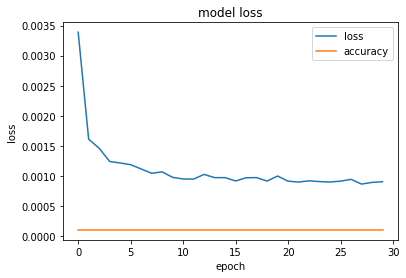

In [15]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

In [16]:
actual_prices = test['Open'].values
total_dataset = pd.concat((train['Open'], test['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [17]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

81/81 [==============================] - 1s 4ms/step


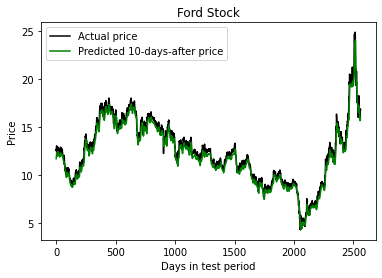

In [19]:
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"Predicted 10-days-after price")
plt.title(f"Ford Stock")
plt.xlabel("Days in test period")
plt.ylabel(f"Price")
plt.legend()
plt.show()